<img height="150" src="https://raw.githubusercontent.com/mmattamala/LogosFCFM/master/Ingenier%C3%ADa%20El%C3%A9ctrica/fcfm_die_png.png">


# **Activity 1**
# EL7044-1 Conceptos Avanzados en Redes Inalámbricas - Spring 2024
---

**Diego Torreblanca**

**Professor**: Shaharyar Kamal

**Assistant professor**: Jorge Sandoval

22/08/24

## Comments on CSMA/CD Paper

Link Paper: [Implementation of CSMA/CD and Link State Routing Protocols for Dijkstra Algorithm](https://ieeexplore.ieee.org/document/10292084)

At first, the paper presents a good State of the Art articles about how to improve CSMA/CD performance using machine learning with adaptive parameters or some enhanced versions of Dijkstra algorithm, but doesn't implement any of that.

The **contribution of the paper** is that the authors present an implementation in MATLAB for simulating a network with CSMA/CD and Link State Routing with Dijkstra algorithm. However, the full code is not shared with the paper and it cannot be found on the internet, so it is limited to the Methodology of the document, which states the following:

For the CSMA/CD implementation:

1.   To generate random transmission attempts, you can use the "rand" function to obtain random number. It doesn't get more specific than that.
2.   Later, when a collision has occurred, the "timer" function in MATLAB can be used to simulate the backoff time.

For Link State Routing with Dijkstra:

1.   Create a **graph object** (doesn't say how) and assign weights or fees to each edge, to simulate the network.
2.   Using the "shortest path" function you can implement Dijkstra algorithm.
3.   Finally, the "plot" function is used to display the network graph and the shortest path between two nodes.

That's all the methodology says about implement those protocols, so it is not that clear how to do it. They do not give a picture for the graph or network distribution, so it is hard to understand how the packets flow from one node to another.

Reviewing the **Simulation Results** section, it shows some plots with bad resolution so it is difficult to analyze the results, and in some points, it declares that the network improved significantly its performance, but doesn't compare it to nothing.

With all this in mind, the paper presents a good idea by saying how to implement a simple code for CSMA/CD and Link State Routing for network engineers, academics and maybe college students with some knowledge about programming, but not in depth, so they can get much comfortable with the code without spending too much time understanding it. However, the code or pseudo-code is not given, so it is practically impossible to run by yourself the simulation and compare the results with the paper.



## CSMA/CD Algorithm Implementation

CSMA/CD Flowchart: https://www.researchgate.net/profile/Saravanan-Anna-Malai/publication/323511648/figure/fig3/AS:631600802983960@1527596774658/Flow-diagram-for-the-CSMA-CD.png

Adapted from: https://github.com/thanujann/CSMA-CD-Protocol-Simulator


In [ ]:
# CSMA/CD Algorithm
import random
import math
import collections
import matplotlib.pyplot as plt


maxSimulationTime = 200
total_num = 0
class Node:
    def __init__(self, location, A):
        self.queue = collections.deque(self.generate_queue(A))
        self.location = location  # Defined as a multiple of D
        self.collisions = 0
        self.wait_collisions = 0
        self.MAX_COLLISIONS = 15


    # It detects a collision
    def collision_occured(self, R):
        self.collisions += 1 # Collision counter
        if self.collisions > self.MAX_COLLISIONS:
            # Drop packet and reset collisions
            return self.pop_packet()

        # Add the exponential backoff time to waiting time
        backoff_time = self.queue[0] + self.exponential_backoff_time(R, self.collisions)

        for i in range(len(self.queue)):
            if backoff_time >= self.queue[i]:
                self.queue[i] = backoff_time
            else:
                break

    # Successful transmission, resets collisions counter to zero
    def successful_transmission(self):
        self.collisions = 0
        self.wait_collisions = 0

    # Generates queue
    def generate_queue(self, A):
        packets = []
        arrival_time_sum = 0
        while arrival_time_sum <= maxSimulationTime:
            arrival_time_sum += get_exponential_random_variable(A)
            packets.append(arrival_time_sum)
        return sorted(packets)

    # Generates exponential waiting time
    def exponential_backoff_time(self, R, general_collisions):
        rand_num = random.random() * (pow(2, general_collisions) - 1)
        return rand_num * 512/float(R)  # 512 bit-times

    def pop_packet(self):
        self.queue.popleft()
        self.collisions = 0
        self.wait_collisions = 0

    def non_persistent_bus_busy(self, R):
        self.wait_collisions += 1
        if self.wait_collisions > self.MAX_COLLISIONS:
            # Drop packet and reset collisions
            return self.pop_packet()

        # Add the exponential backoff time to waiting time
        backoff_time = self.queue[0] + self.exponential_backoff_time(R, self.wait_collisions)

        for i in range(len(self.queue)):
            if backoff_time >= self.queue[i]:
                self.queue[i] = backoff_time
            else:
                break


def get_exponential_random_variable(param):
    # Get random value between 0 (exclusive) and 1 (inclusive)
    # uniform_random_value = 1 - random.uniform(0, 1)
    uniform_random_value = 1 - random.random()
    # exponential_random_value = (-math.log(1 - uniform_random_value) / float(param))

    # return exponential_random_value
    return uniform_random_value


def build_nodes(N, A, D):
    nodes = []
    for i in range(0, N):
        nodes.append(Node(i*D, A))
    return nodes

def csma_cd(N, A, R, L, D, S, is_persistent):
    curr_time = 0
    transmitted_packets = 0
    successfuly_transmitted_packets = 0
    nodes = build_nodes(N, A, D)

    while True:

    # Step 1: Pick the smallest time out of all the nodes
        min_node = Node(None, A)  # Some random temporary node
        min_node.queue = [float("infinity")]
        for node in nodes:
            if len(node.queue) > 0:
                min_node = min_node if min_node.queue[0] < node.queue[0] else node

        if min_node.location is None:  # Terminate if no more packets to be delivered
            break

        curr_time = min_node.queue[0]
        transmitted_packets += 1

        # Step 2: Check if collision will happen
        # Check if all other nodes except the min node will collide
        collsion_occurred_once = False
        for node in nodes:
            if node.location != min_node.location and len(node.queue) > 0:
                delta_location = abs(min_node.location - node.location)
                t_prop = delta_location / float(S)
                t_trans = L/float(R)

                # Check collision
                will_collide = True if node.queue[0] <= (curr_time + t_prop) else False

                # Sense bus busy
                if (curr_time + t_prop) < node.queue[0] < (curr_time + t_prop + t_trans):
                    if is_persistent is True:
                        for i in range(len(node.queue)):
                            if (curr_time + t_prop) < node.queue[i] < (curr_time + t_prop + t_trans):
                                node.queue[i] = (curr_time + t_prop + t_trans)
                            else:
                                break
                    else:
                        node.non_persistent_bus_busy(R)

                if will_collide:
                    collsion_occurred_once = True
                    transmitted_packets += 1
                    node.collision_occured(R)

        # Step 3: If a collision occured then retry
        # otherwise update all nodes latest packet arrival times and proceed to the next packet
        if not collsion_occurred_once:  # If no collision happened
            successfuly_transmitted_packets += 1
            min_node.pop_packet()
        elif not collsion_occurred_once:
          if random.random() > 0.001 * (L/1000):
            successfuly_transmitted_packets += 1
            min_node.pop_packet()
        else:    # If a collision occurred
            min_node.collision_occured(R)


    effeciency = successfuly_transmitted_packets/float(transmitted_packets)
    throughput = (L * successfuly_transmitted_packets) / float(curr_time + (L/R)) * pow(10, -6)

    return effeciency, throughput



### Define System Parameters

*   Average packet arrival rate (packets per second): 10
*   The speed of the LAN/channel/bus (in b/s): 1 Mb/s
*   Distance between adjacent nodes on the bus/channel: 10
*   Propagation speed (m/s): $\frac{2}{3} C$


In [ ]:
# Run Algorithm
# N = The number of nodes/computers connected to the LAN
# A = Average packet arrival rate (packets per second)
# R = The speed of the LAN/channel/bus (in b/s)
# L = Packet length (in bits)
# D = Distance between adjacent nodes on the bus/channel
# S = Propagation speed (meters/sec)
# is_persistent (bool)

A = 10
R = 1 * pow(10, 6) # 1 Mb/s
D = 10
C = 3 * pow(10, 8) # speed of light
S = (2/3.0) * C

colors = ['b', 'g', 'r', 'c']

## Testing CSMA/CD by changing number of nodes

Packet sizes for testing: 1500, 2000, 4000 and 8000 bits.

In [ ]:
# N
nodes = [i for i in range(10, 41,5)]
test_packets = [1500, 2000, 4000, 8000]
nodes_effeciency = [[], [], [], []]
nodes_thp = [[], [], [], []]
nodes_effeciency_non = [[], [], [], []]
nodes_thp_non = [[], [], [], []]

for j in range(len(test_packets)):
  for N in nodes:
        L = test_packets[j]
        effeciency, throughput= csma_cd(N, A, R, L, D, S, True)
        nodes_effeciency[j].append(effeciency)
        nodes_thp[j].append(throughput)
        effeciency_non, throughput_non= csma_cd(N, A, R, L, D, S, False)
        nodes_effeciency_non[j].append(effeciency_non)
        nodes_thp_non[j].append(throughput_non)


### Plots

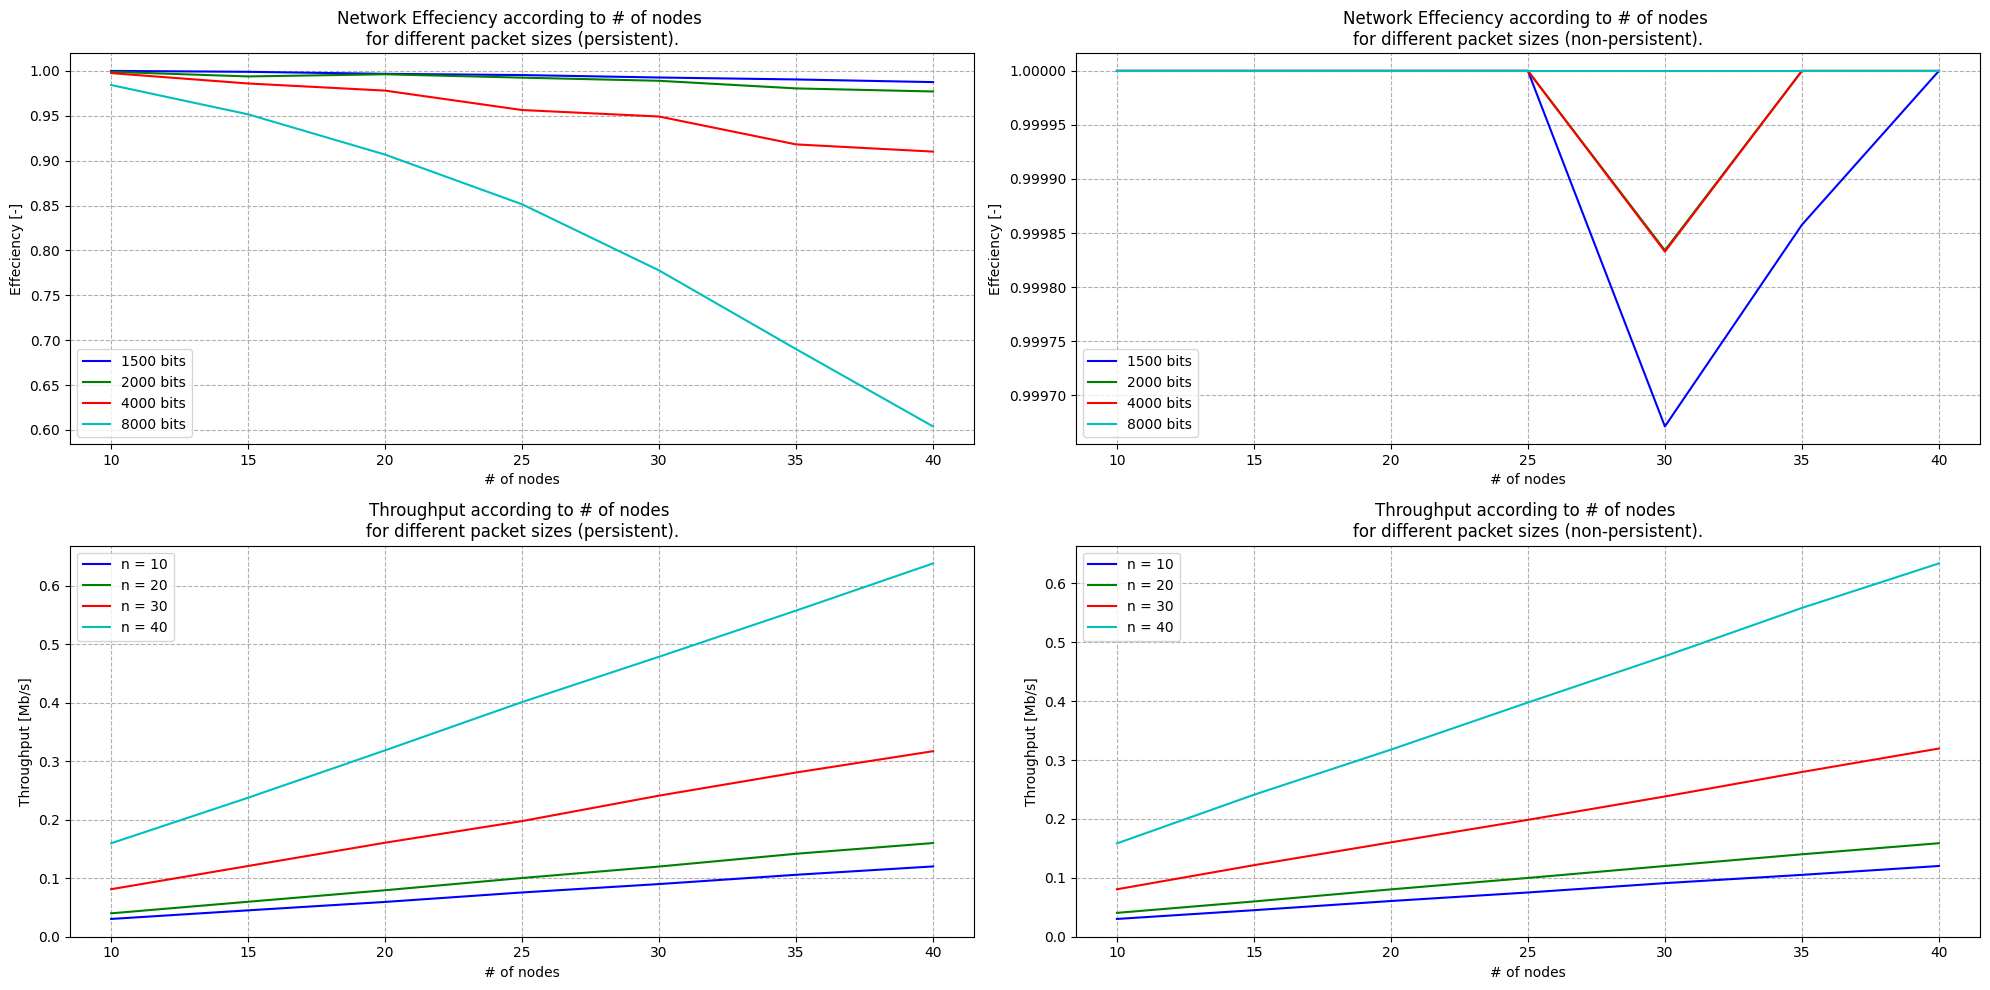

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

for j in range(len(test_packets)):
    ax1.plot(nodes, nodes_effeciency[j], colors[j])
    ax2.plot(nodes, nodes_effeciency_non[j], colors[j])
    ax3.plot(nodes, nodes_thp[j], colors[j])
    ax4.plot(nodes, nodes_thp_non[j], colors[j])

ax1.set_xlabel('# of nodes')
ax1.set_ylabel('Effeciency [-]')
ax1.set_title('Network Effeciency according to # of nodes \nfor different packet sizes (persistent).')
ax1.grid(linestyle='--')
ax1.legend(['1500 bits','2000 bits', '4000 bits', '8000 bits'])

ax2.set_xlabel('# of nodes')
ax2.set_ylabel('Effeciency [-]')
ax2.set_title('Network Effeciency according to # of nodes \nfor different packet sizes (non-persistent).')
ax2.grid(linestyle='--')
ax2.legend(['1500 bits','2000 bits', '4000 bits', '8000 bits'])

ax3.set_xlabel('# of nodes')
ax3.set_ylabel('Throughput [Mb/s]')
ax3.set_title('Throughput according to # of nodes \nfor different packet sizes (persistent).')
ax3.grid(linestyle='--')
ax3.legend(['n = 10', 'n = 20', 'n = 30', 'n = 40'])

ax4.set_xlabel('# of nodes')
ax4.set_ylabel('Throughput [Mb/s]')
ax4.set_title('Throughput according to # of nodes \nfor different packet sizes (non-persistent).')
ax4.grid(linestyle='--')
ax4.legend(['n = 10', 'n = 20', 'n = 30', 'n = 40'])

plt.tight_layout()
plt.show()
plt.close()

## Testing CSMA/CD by changing packet length

Number of nodes for testing: 10, 20, 30 and 40.

In [ ]:
# L
packets = [i for i in range(100*8,2000*8+1,800)]
test_nodes = [10, 20, 30, 40]
packets_effeciency = [[], [], [], []]
packets_thp = [[], [], [], []]
packets_effeciency_non = [[], [], [], []]
packets_thp_non = [[], [], [], []]

for j in range(len(test_nodes)):
  for L in packets:
        N = test_nodes[j]
        effeciency, throughput= csma_cd(N, A, R, L, D, S, True)
        packets_effeciency[j].append(effeciency)
        packets_thp[j].append(throughput)
        effeciency_non, throughput_non= csma_cd(N, A, R, L, D, S, False)
        packets_effeciency_non[j].append(effeciency)
        packets_thp_non[j].append(throughput)

### Plots

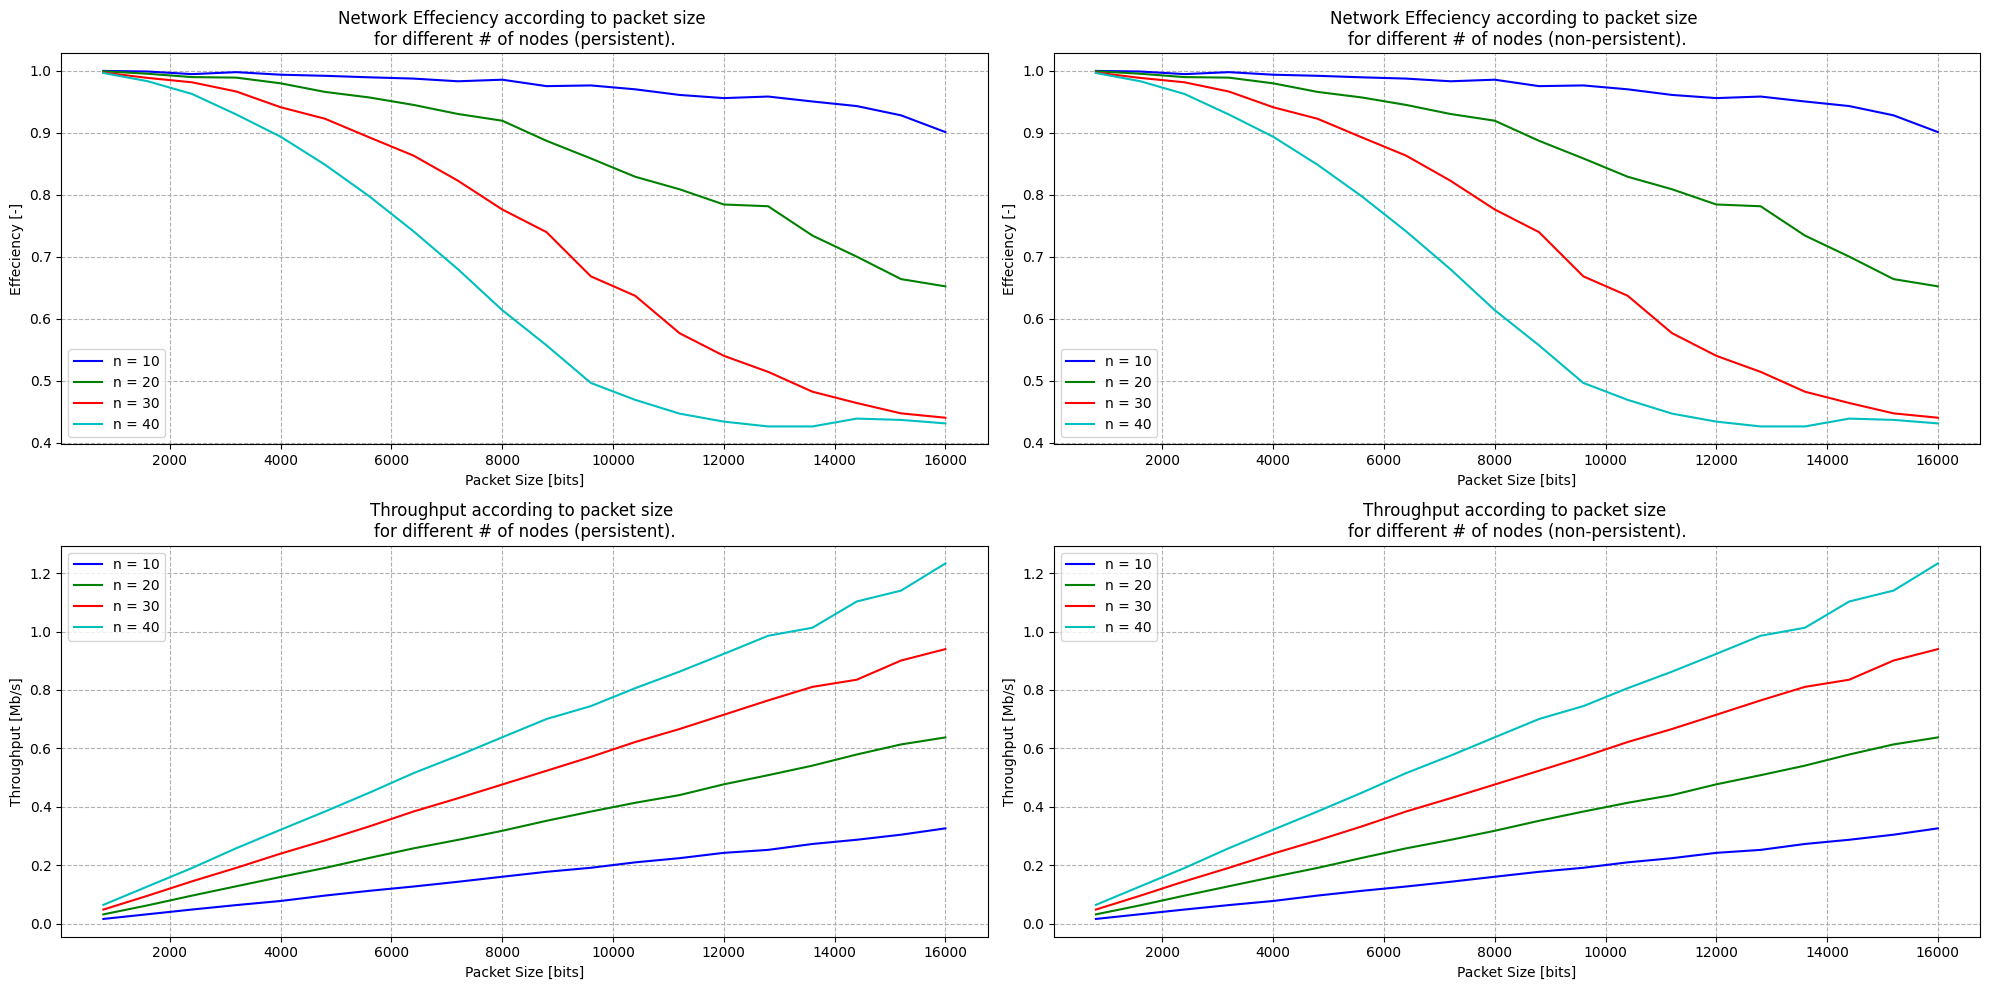

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

for j in range(len(test_nodes)):
    ax1.plot(packets, packets_effeciency[j], colors[j])
    ax2.plot(packets, packets_effeciency_non[j], colors[j])
    ax3.plot(packets, packets_thp[j], colors[j])
    ax4.plot(packets, packets_thp_non[j], colors[j])

ax1.set_xlabel('Packet Size [bits]')
ax1.set_ylabel('Effeciency [-]')
ax1.set_title('Network Effeciency according to packet size \nfor different # of nodes (persistent).')
ax1.grid(linestyle='--')
ax1.legend(['n = 10', 'n = 20', 'n = 30', 'n = 40'])

ax2.set_xlabel('Packet Size [bits]')
ax2.set_ylabel('Effeciency [-]')
ax2.set_title('Network Effeciency according to packet size \nfor different # of nodes (non-persistent).')
ax2.grid(linestyle='--')
ax2.legend(['n = 10', 'n = 20', 'n = 30', 'n = 40'])

ax3.set_xlabel('Packet Size [bits]')
ax3.set_ylabel('Throughput [Mb/s]')
ax3.set_title('Throughput according to packet size \nfor different # of nodes (persistent).')
ax3.grid(linestyle='--')
ax3.legend(['n = 10', 'n = 20', 'n = 30', 'n = 40'])

ax4.set_xlabel('Packet Size [bits]')
ax4.set_ylabel('Throughput [Mb/s]')
ax4.set_title('Throughput according to packet size \nfor different # of nodes (non-persistent).')
ax4.grid(linestyle='--')
ax4.legend(['n = 10', 'n = 20', 'n = 30', 'n = 40'])

plt.tight_layout()
plt.show()